### **Part 2**
**Tasks**

**!!!Remember to change code for modularity and quicker with GPU**

* explore proper visual stimuli
  * spontaneous state
  * (done) evoked state: drifting
* Communication subspaces across different areas
  * (done) correlation
  * *dimensionality*
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * (done) direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * (done) inter_areas cca_delay
    * *intra_areas cca_delay (layer_dependent)*
    * *feedfward and feedback*
  * function validation
* Relation between different information flow channels
  * *subspace & layer_dependent*
  * *shared dimensionility*
  * *input/output dimensions*
  * *generalize canonical dimension across subspaces*
  * subspaces angle
  * CCA across subspaces
  * predictive coding
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache


In [ ]:

# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_id = 799864342
session = cache.get_session_data(session_id)

drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

In [2]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        stim_table -- _description_

    Keyword Arguments:
        bin -- _description_ (default: {0.1})
        period -- _description_ (default: {2})

    Returns:
        _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

### Task4 Dimensionity of subspaces intra-areas and inter-areas

In [4]:
response_matrix = spike_matrix(area='VISp', stim_table=drift_stim_table)
res_mat = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                response_matrix.shape[2])
print(res_mat.shape)

['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
(12600, 75)


intra Dimensionity got by FA

In [30]:
def cross_val_FA(res_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(res_mat):
        train, test = res_mat[train_index], res_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()


64


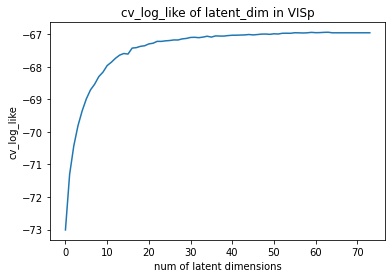

In [46]:
N, n_features = res_mat.shape

# select proper latent dimensions from [1, p-1]
cv_log_like = np.zeros(n_features-1)
for i in range(n_features-1):
    latent_dim = i + 1
    cv_log_like[i] = cross_val_FA(res_mat, latent_dim)

latent_dim_log_like = np.argmax(cv_log_like) + 1
print(latent_dim_log_like)

plt.figure()
plt.plot(cv_log_like)
plt.title(f'cv_log_like of latent_dim in VISp')
plt.xlabel('num of latent dimensions')
# plt.xticks(ticks=tick_bins, labels=label_bins)
plt.ylabel('cv_log_like')
plt.show()

14


/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


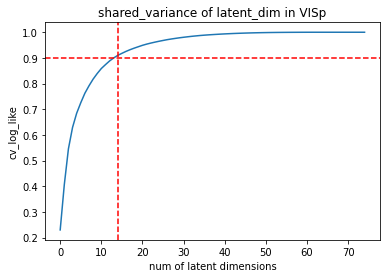

In [47]:

# select proper latent dimensions with best dim got by log_like

fa = FactorAnalysis(n_components=latent_dim_log_like)
fa.fit(res_mat)
load_mat = fa.components_   # (n_components, n_features)

eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
ind = np.argsort(-eigvals)
eigvals = eigvals[ind]
shared_var = np.cumsum(eigvals)/np.sum(eigvals)

threshold = 0.9
latent_dim = np.where(shared_var>threshold)[0][0]
print(latent_dim)

plt.figure()
plt.plot(shared_var)
plt.axvline(x=latent_dim, ls='--', c='red') 
plt.axhline(y=threshold, ls='--', c='red') 
plt.title(f'shared_variance of latent_dim in VISp')
plt.xlabel('num of latent dimensions')
# plt.xticks(ticks=tick_bins, labels=label_bins)
plt.ylabel('cv_log_like')
plt.show()

# # Create factor analysis object and perform factor analysis
# fa = FactorAnalysis(n_components=latent_dim)
# fa.fit(res_mat)
# load_mat = fa.components_   # (n_components, n_features)
# psi = fa.noise_variance_    # (n_features)
# z = fa.transform(res_mat)

In [48]:
def intra_dim_FA(area):

    response_matrix = spike_matrix(area=area, stim_table=drift_stim_table)
    res_mat = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])
    
    N, n_features = res_mat.shape

    # select proper latent dimensions from [1, p-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_FA(res_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(res_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim

18
['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
16
['VISam', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/decomposition/_factor_analysis.py:256: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/decomposition/_factor_analysis.py:256: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/decomposition/_factor_analysis.py:256: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


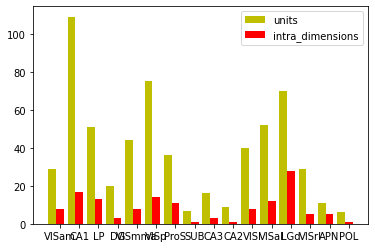

In [51]:
areas = session.structure_acronyms
print(len(areas))
print(areas)

# delete nan in areas
while np.nan in areas:
    areas.remove(np.nan)

# delete area with no units
for area in areas:
    units = session.units[session.units["ecephys_structure_acronym"] == area]
    if units.shape[0] == 0:
        areas.remove(area)
print(len(areas))
print(areas)

# areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
# print(len(areas_sorted))
# print(areas_sorted)

# intra_dimension for all areas
units_area = np.zeros(len(areas))
intra_dim_area = np.zeros(len(areas))
for i, area in enumerate(areas):
    units_area[i] = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]
    intra_dim_area[i] = intra_dim_FA(area)


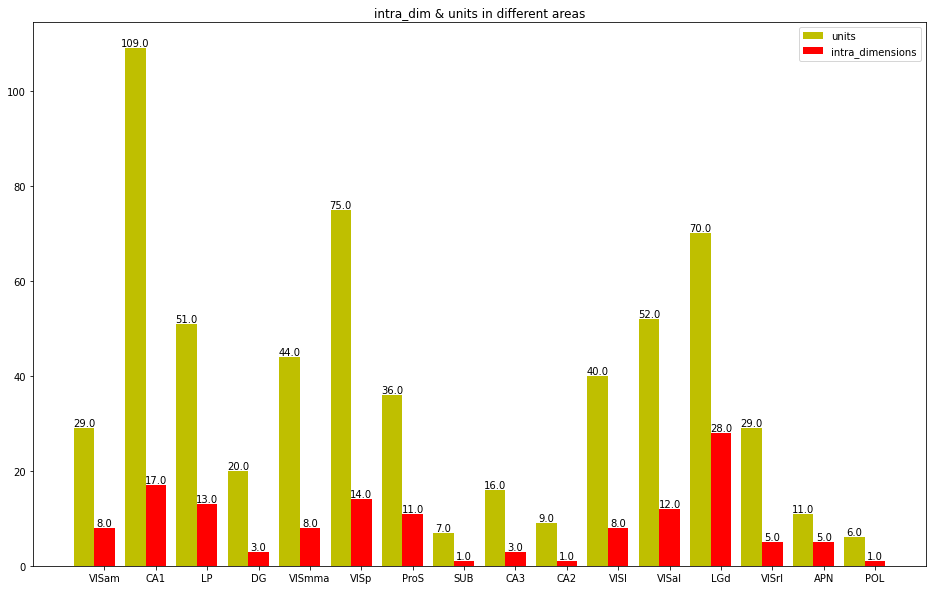

In [65]:

x = np.array(range(len(areas)))
width=0.4
plt.figure(figsize=(16, 10))
plt.bar(x, units_area, width=width, label='units',fc='y')
plt.bar(x+np.array([width]), intra_dim_area, width=width, label='intra_dimensions', tick_label=areas, fc='r')
plt.legend()

for a, b in zip(x, units_area):   #柱子上的数字显示
    plt.text(a, b, b, ha='center', va='bottom')
for a, b in zip(x+width, intra_dim_area):
    plt.text(a, b, b, ha='center', va='bottom')

plt.title(f'intra_dim & units in different areas')
plt.show()


inter Dimensionity got by pCCA

In [52]:
def cross_val_pCCA(res_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(res_mat):
        train, test = res_mat[train_index], res_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(area_1, area_2):

    response_matrix = spike_matrix(area=area_1, stim_table=drift_stim_table)
    res_mat_1 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])
    response_matrix = spike_matrix(area=area_2, stim_table=drift_stim_table)
    res_mat_2 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])
    
    res_mat = np.concatenate((res_mat_1, res_mat_2), axis = 1)

    N, n_features = res_mat.shape
    _, n_features_1 = res_mat_1.shape
    _, n_features_2 = res_mat_2.shape

    # select proper latent dimensions from [1, n_features-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_pCCA(res_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(res_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim, (load_mat_1, load_mat_2)

In [66]:
# inter_dimension across every two areas

f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 25), sharex=True)
width=0.16
x = np.array(range(len(areas)))
inter_dim_areas = np.zeros([len(areas), len(areas)])

for i, area_1 in enumerate(areas):
    units_area_1 = np.ones_like(x) * units_area[i]
    intra_dim_area_1 = np.ones_like(x) * intra_dim_area[i]

    for j, area_2 in enumerate(areas):
        inter_dim_areas[i, j] = inter_dim_pCCA(area_1, area_2)
        units_area_2 = np.ones_like(x) * units_area[j]
        intra_dim_area_2 = np.ones_like(x) * intra_dim_area[j]

    axes[i].bar(x, units_area_1, width=width, label='units_area_1', fc='r')
    axes[i].bar(x+np.array([width]), intra_dim_area_1, width=width, label='intra_dim_1', fc='y') 
    axes[i].bar(x+np.array([2*width]), inter_dim_areas[i, :], width=width, label='inter_dim_areas', fc='g')
    axes[i].bar(x+np.array([3*width]), intra_dim_area_2, width=width, label='intra_dim_2', fc='b')
    axes[i].bar(x+np.array([4*width]), units_area_2, width=width, label='units_area_2', tick_label=areas, fc='c')
    axes[i].set_ylabel(f'{area_1}')
    axes[i].legend()

f.suptitle('inter_dimension & intra_dimension across every two areas')
plt.tight_layout()
plt.show()

***********************************************************************
Below Code copy from part4 for debug
***********************************************************************

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session = cache.get_session_data(755434585)
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,225,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.891887,2,drifting_gratings,1587.893537,1,2.00165,246
3799,0.8,270,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1588.894403,2,drifting_gratings,1590.896063,2,2.00166,247
3800,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1591.896927,2,drifting_gratings,1593.898597,8,2.00167,248
3801,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1594.899423,2,drifting_gratings,1596.901083,2,2.00166,249
3802,0.8,315,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1597.901957,2,drifting_gratings,1599.903567,2,2.00161,250


In [3]:
def get_units_area(areas, session):

    units_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        units_area[i] = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]

    return units_area

def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def get_design_matrix(area, stim_table):
    """get_design_matrix design_matrix for further analysis

    Reshape response_matrix from (stims, bins, units) to (stims*bins, units)/(n_samples, units)

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        design_matrix, shape (n_samples, units)
    """

    response_matrix = spike_matrix(area=area, stim_table=stim_table)
    design_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return design_matrix

In [10]:
def cross_val_pCCA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(des_mat_1, des_mat_2):
    
    des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)

    N, n_features = des_mat.shape
    _, n_features_1 = des_mat_1.shape
    _, n_features_2 = des_mat_2.shape

    # # select proper latent dimensions from [1, n_features-1]
    # cv_log_like = np.zeros(n_features-1)
    # for i in range(n_features-1):
    #     latent_dim = i + 1
    #     cv_log_like[i] = cross_val_pCCA(des_mat, latent_dim)

    # latent_dim_log_like = np.argmax(cv_log_like) + 1
    # print('latent_dim_log_like', latent_dim_log_like)

    # # select proper latent dimensions with best dim got by log_like

    # select proper latent dimensions from [1, p-1]
    if n_features > 20:
        # as n_features is more, cv_log_like is more
        # so to save time, limit 20 possible dim to try
        start_feature = n_features - 20
        cv_log_like = np.zeros(20)
        features = range(n_features)[start_feature:]
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)     
    else:
        cv_log_like = np.zeros(n_features-1)
        features = range(n_features-1) + 1
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = features[np.argmax(cv_log_like) + 1]

    # select proper latent dimensions with best dim got by log_like

    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]
    print('latent_dim', latent_dim)

    # use the proper latent_dim to fit
    fa = FactorAnalysis(n_components=latent_dim)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    return latent_dim, (load_mat_1, load_mat_2)

def get_inter_dim_area(areas, stim_table):

    inter_dim_areas = np.zeros([len(areas), len(areas)])
    pCCA_load_mat_1 = {}
    pCCA_load_mat_2 = {}

    for i, area_1 in enumerate(areas):
        des_mat_1 = get_design_matrix(area_1, stim_table)
        for j, area_2 in enumerate(areas):
            name = area_1 + '_' + area_2
            des_mat_2 = get_design_matrix(area_2, stim_table)
            inter_dim_areas[i, j], (pCCA_load_mat_1[name], pCCA_load_mat_2[name]) = inter_dim_pCCA(des_mat_1, des_mat_2)
            
    # print('inter_dim_areas', inter_dim_areas)

    return inter_dim_areas, pCCA_load_mat_1, pCCA_load_mat_2

def plot_inter_dim_areas(areas, intra_dim_area, inter_dim_areas):
    # inter_dimension across every two areas

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 50), sharex=True)

    width=0.25
    x = np.array(range(len(areas)))
    intra_dim_area_2 = intra_dim_area

    for i, area_1 in enumerate(areas):

        intra_dim_area_1 = np.ones_like(x) * intra_dim_area[i]

        axes[i].bar(x, intra_dim_area_1, width=width, label='intra_dim_1', fc='r') 
        axes[i].bar(x+np.array([width]), inter_dim_areas[i, :], width=width, label='inter_dim', fc='g')
        axes[i].bar(x+np.array([2*width]), intra_dim_area_2, width=width, label='intra_dim_2', tick_label=areas, fc='b')
        axes[i].set_ylabel(f'{area_1}')
        axes[i].legend()

    f.suptitle('inter_dimension & intra_dimension across every two areas')
    plt.tight_layout()
    plt.show()

In [31]:
des_mat_1 = get_design_matrix('VISp', drift_stim_table)
des_mat_2 = get_design_matrix('VISp', drift_stim_table)
des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)
fa = FactorAnalysis(n_components=latent_dim)
fa.fit(des_mat)

FactorAnalysis(n_components=8)

In [33]:
def get_load_mat_from_latent_dim(inter_dim_areas, areas, stim_table):

    pCCA_load_mat_1 = {}
    pCCA_load_mat_2 = {}

    for i, area_1 in enumerate(areas):
        des_mat_1 = get_design_matrix(area_1, stim_table)
        _, n_features_1 = des_mat_1.shape
        for j, area_2 in enumerate(areas):
            des_mat_2 = get_design_matrix(area_2, stim_table)
            des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)
            print(des_mat.shape)
            latent_dim = int(inter_dim_areas[i, j])
            print(latent_dim)
            name = area_1 + '_' + area_2
            # use the proper latent_dim to fit
            fa = FactorAnalysis(n_components=latent_dim)
            fa.fit(des_mat)
            load_mat = fa.components_   # (n_components, n_features)
            pCCA_load_mat_1[name] = load_mat[:, :n_features_1]
            pCCA_load_mat_2[name] = load_mat[:, n_features_1:]

    return pCCA_load_mat_1, pCCA_load_mat_2

inter_dim_areas = np.load('inter_dim_areas_755434585.npy')
pCCA_load_mat_1, pCCA_load_mat_2  = get_load_mat_from_latent_dim(inter_dim_areas, areas, stim_table=drift_stim_table)
np.save('pCCA_load_mat_1_755434585', pCCA_load_mat_1)
np.save('pCCA_load_mat_2_755434585', pCCA_load_mat_2)

(12600, 150)
32
(12600, 124)
9
(12600, 114)
10
(12600, 117)
10
(12600, 137)
9
(12600, 169)
13
(12600, 119)
15
(12600, 102)
11
(12600, 124)
9
(12600, 98)
22
(12600, 88)
8
(12600, 91)
8
(12600, 111)
8
(12600, 143)
11
(12600, 93)
13
(12600, 76)
12
(12600, 114)
10
(12600, 88)
8
(12600, 78)
22
(12600, 81)
9
(12600, 101)
8
(12600, 133)
10
(12600, 83)
12
(12600, 66)
11
(12600, 117)
10
(12600, 91)
8
(12600, 81)
9
(12600, 84)
21
(12600, 104)
9
(12600, 136)
11
(12600, 86)
11
(12600, 69)
10
(12600, 137)
9
(12600, 111)
8
(12600, 101)
8
(12600, 104)
9
(12600, 124)
25
(12600, 156)
12
(12600, 106)
12
(12600, 89)
11
(12600, 169)
13
(12600, 143)
11
(12600, 133)
10
(12600, 136)
11
(12600, 156)
12
(12600, 188)
43
(12600, 138)
15
(12600, 121)
13
(12600, 119)
15
(12600, 93)
13
(12600, 83)
12
(12600, 86)
11
(12600, 106)
12
(12600, 138)
15
(12600, 88)
29
(12600, 71)
11
(12600, 102)
12
(12600, 76)
12
(12600, 66)
11
(12600, 69)
10
(12600, 89)
11
(12600, 121)
13
(12600, 71)
11
(12600, 54)
17


In [12]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

inter_dim_areas, pCCA_load_mat_1, pCCA_load_mat_2 = get_inter_dim_area(areas, stim_table=drift_stim_table)
np.save('inter_dim_areas_755434585', inter_dim_areas)
np.save('pCCA_load_mat_1_755434585', pCCA_load_mat_1)
np.save('pCCA_load_mat_2_755434585', pCCA_load_mat_2)

latent_dim 32
latent_dim 9
latent_dim 10
latent_dim 10
latent_dim 9
latent_dim 13
latent_dim 15
latent_dim 11
latent_dim 9
latent_dim 22
latent_dim 8
latent_dim 8
latent_dim 8
latent_dim 11
latent_dim 13
latent_dim 12
latent_dim 10
latent_dim 8
latent_dim 22
latent_dim 9
latent_dim 8
latent_dim 10
latent_dim 12
latent_dim 11
latent_dim 10
latent_dim 8
latent_dim 9
latent_dim 21
latent_dim 9
latent_dim 11
latent_dim 11
latent_dim 10
latent_dim 9
latent_dim 8
latent_dim 8
latent_dim 9
latent_dim 25
latent_dim 12
latent_dim 12
latent_dim 11
latent_dim 13
latent_dim 11
latent_dim 10
latent_dim 11
latent_dim 12
latent_dim 43
latent_dim 15
latent_dim 13
latent_dim 15
latent_dim 13
latent_dim 12
latent_dim 11
latent_dim 12
latent_dim 15
latent_dim 29
latent_dim 11
latent_dim 12
latent_dim 12
latent_dim 11
latent_dim 10
latent_dim 11
latent_dim 13
latent_dim 11
latent_dim 17


NameError: name 'units_area' is not defined

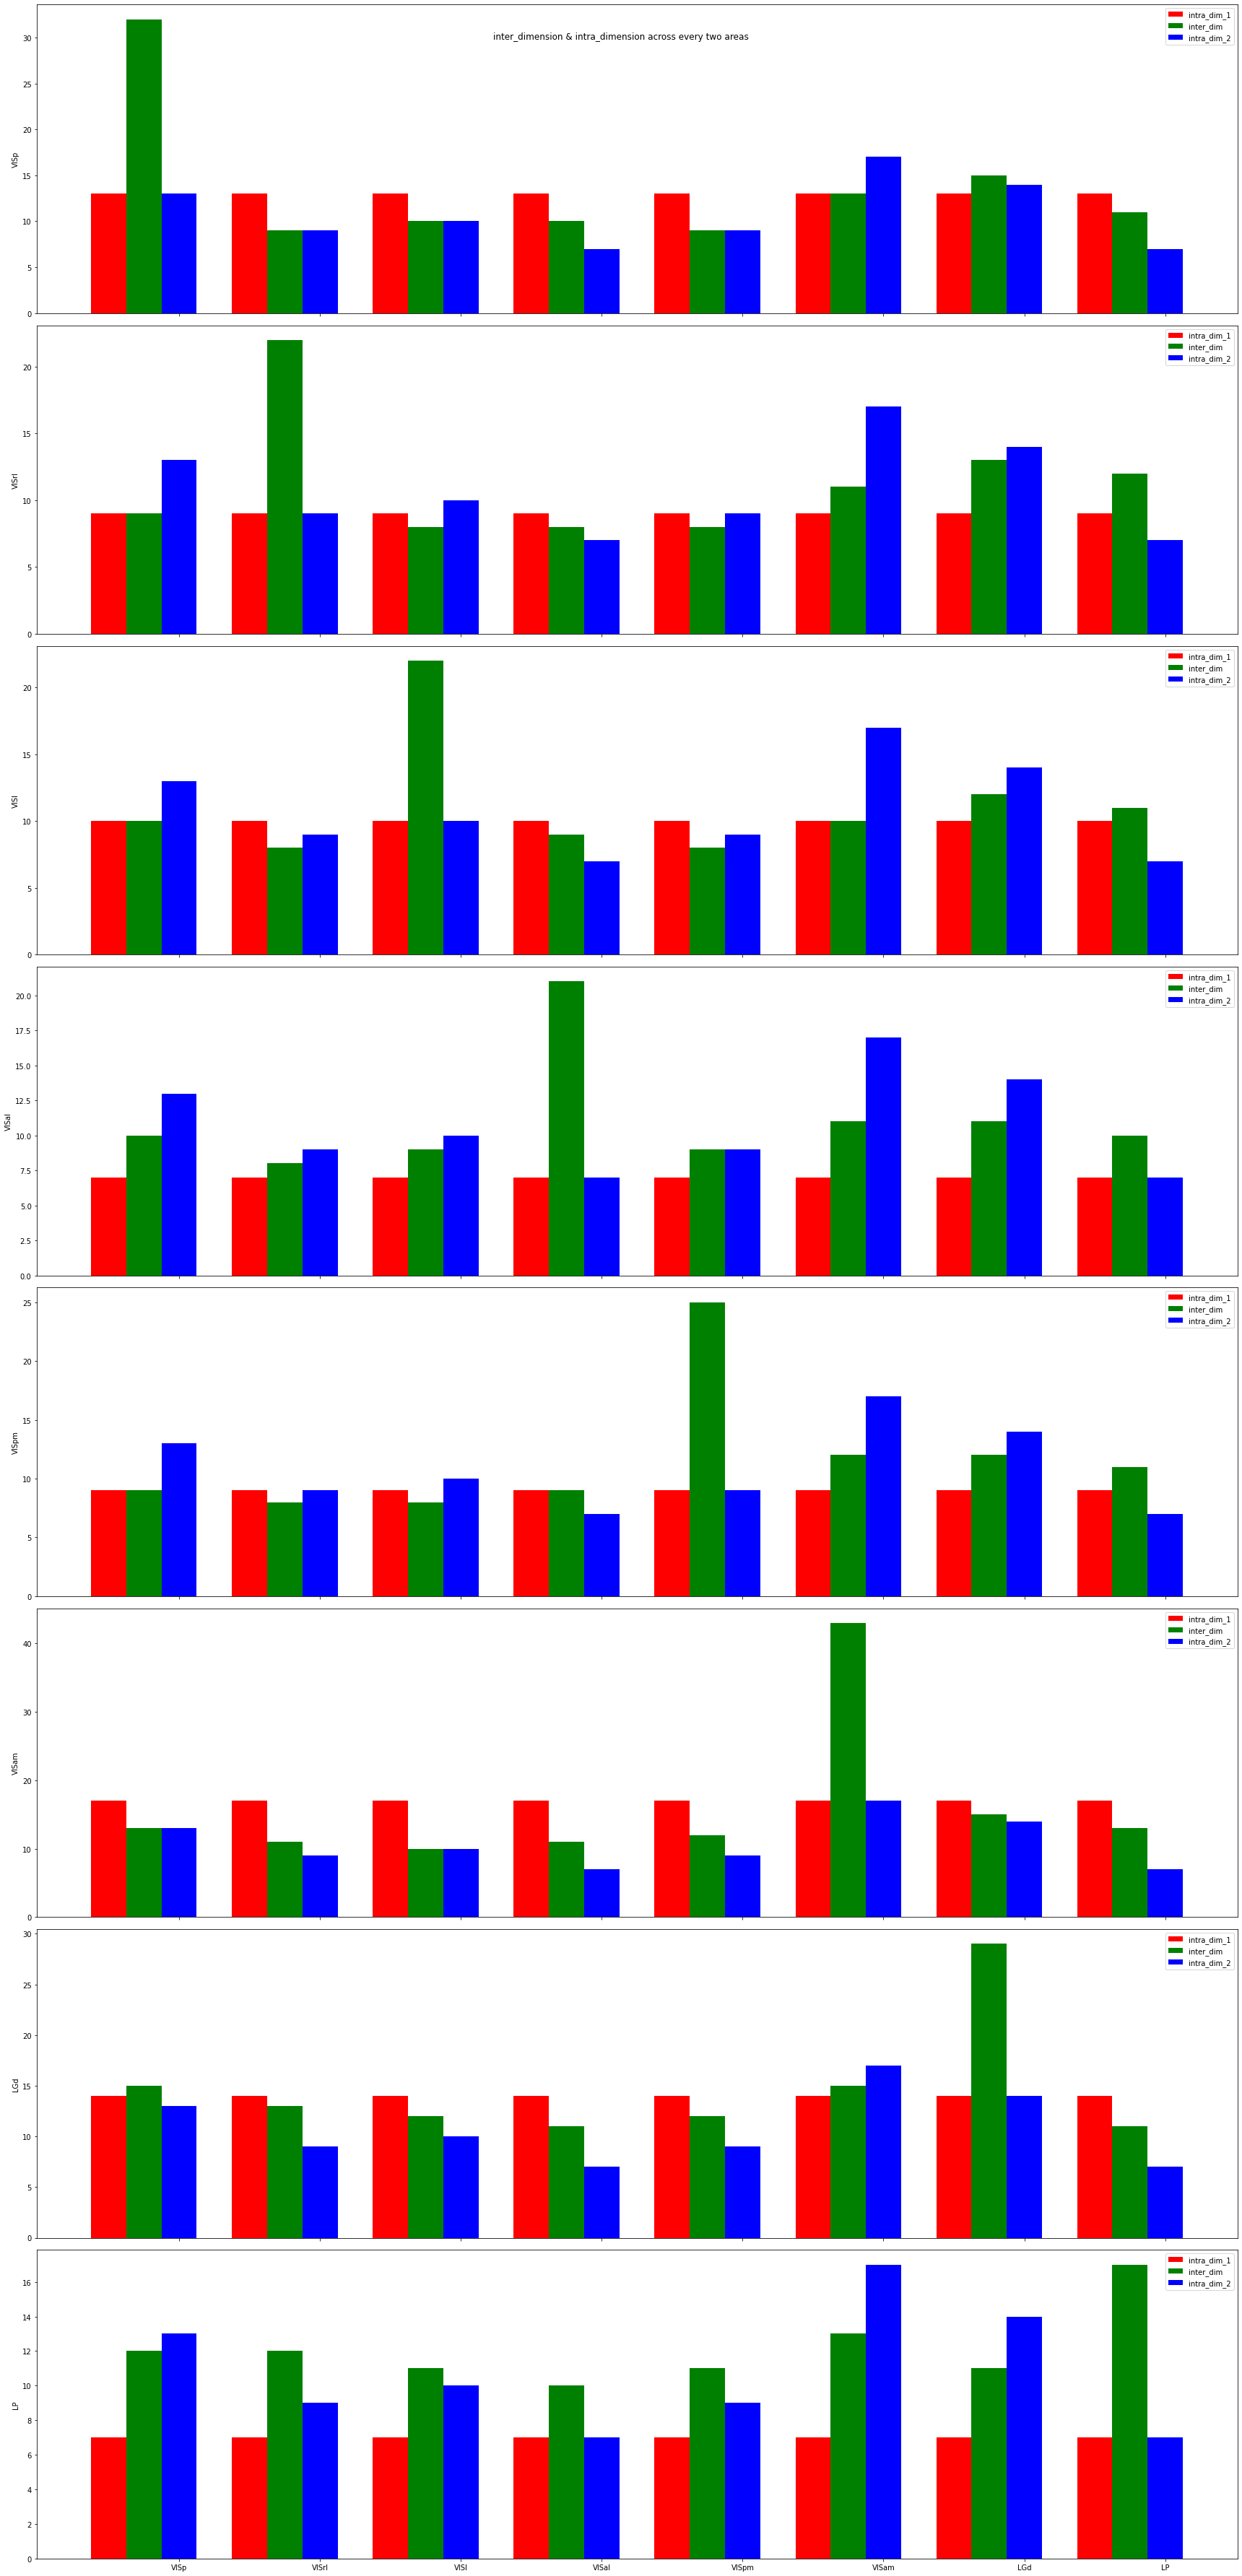

In [15]:
intra_dim_area = np.load('intra_dim_area_755434585.npy')
inter_dim_areas = np.load('inter_dim_areas_755434585.npy')
plot_inter_dim_areas(areas, intra_dim_area, inter_dim_areas)

In [5]:
def cross_val_FA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def intra_dim_FA(des_mat):
    
    N, n_features = des_mat.shape

    # select proper latent dimensions from [1, p-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim, cv_log_like, latent_dim_log_like


def get_intra_dim_area(areas, stim_table):

    intra_dim_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        des_mat = get_design_matrix(area, stim_table)
        intra_dim_area[i] = intra_dim_FA(des_mat)

    print('intra_dim_area', intra_dim_area)

    return intra_dim_area

def plot_intra_dim_areas(areas, units_area, intra_dim_area):

    # intra_dimension for all areas
    x = np.array(range(len(areas)))
    width=0.4
    plt.figure(figsize=(16, 10))
    plt.bar(x, units_area, width=width, label='units',fc='y')
    plt.bar(x+np.array([width]), intra_dim_area, width=width, label='intra_dimensions', tick_label=areas, fc='r')
    plt.legend()

    # show num on the bar
    for a, b in zip(x, units_area):
        plt.text(a, b, b, ha='center', va='bottom')
    for a, b in zip(x+width, intra_dim_area):
        plt.text(a, b, b, ha='center', va='bottom')

    plt.title(f'intra_dim & units in different areas')
    plt.show()

    return

latent_dim_log_like 28
latent_dim 8


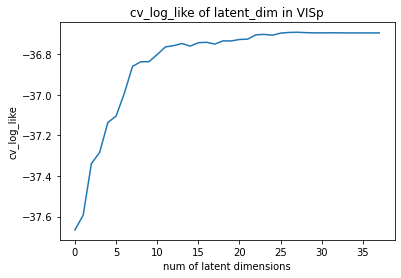

In [6]:
area = 'VISl'
des_mat = get_design_matrix(area, stim_table=drift_stim_table)
latent_dim, cv_log_like, latent_dim_log_like = intra_dim_FA(des_mat)
print('latent_dim_log_like', latent_dim_log_like)
print('latent_dim', latent_dim)

plt.figure()
plt.plot(cv_log_like)
plt.title(f'cv_log_like of latent_dim in VISp')
plt.xlabel('num of latent dimensions')
plt.ylabel('cv_log_like')
plt.show()